## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

## Data Ingestion

In [2]:
pc_df = pd.read_csv("data/laptops_train.csv")
pc_df.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


## Data Cleaning Part I: Transformation

In [3]:
# remove spaces in colum names
pc_df.columns = ["_".join(pc.lower().split()) for pc in pc_df.columns]

# rename columns with operating system info for brevity
pc_df = pc_df.rename(columns={"operating_system":"os", "operating_system_version":"os_version"})

In [4]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  977 non-null    object 
 1   model_name    977 non-null    object 
 2   category      977 non-null    object 
 3   screen_size   977 non-null    object 
 4   screen        977 non-null    object 
 5   cpu           977 non-null    object 
 6   ram           977 non-null    object 
 7   storage       977 non-null    object 
 8   gpu           977 non-null    object 
 9   os            977 non-null    object 
 10  os_version    841 non-null    object 
 11  weight        977 non-null    object 
 12  price         977 non-null    float64
dtypes: float64(1), object(12)
memory usage: 99.4+ KB


In [5]:
# drop columns with null values
pc_df = pc_df.dropna()

In [6]:
# convert price column from INR (rupees) to USD (dollars)
#     1 INR = 0.012 USD now according to Google Finance and Forbes
pc_df.price = pc_df.price*0.012*0.012

# rename price column to include unit (usd)
pc_df = pc_df.rename(columns={"price":"price_usd"})

In [7]:
# create df with some of original info for later reference
pc_info_df = pc_df.copy()

In [8]:
# convert manufacturer to boolean variable
man_df = pd.get_dummies(pc_df.manufacturer)

# remove spaces in column names and indicate category
man_df.columns = ["_".join(x.lower().split())+"_manufac" for x in man_df.columns]

# add boolean category variables to pc_df
pc_df = pc_df.merge(man_df, left_index=True, right_index=True)
pc_df = pc_df.drop(columns=["manufacturer"])

In [9]:
# drop model name column
pc_df = pc_df.drop(columns=["model_name"])

In [10]:
# convert category to boolean variable
cat_df = pd.get_dummies(pc_df.category)

# remove spaces in column names and indicate category
cat_df.columns = ["_".join(cat.lower().split())+"_cat" for cat in cat_df.columns]

# add boolean category variables to pc_df
pc_df = pc_df.merge(cat_df, left_index=True, right_index=True)
pc_df = pc_df.drop(columns=["category"])

In [11]:
# extract screen size with regex and create new column
regex = r"(.*)\""
pc_df["screen_size_in"] = pc_df.screen_size.str.extract(regex, expand=False)
pc_df["screen_size_in"] = pc_df["screen_size_in"].str.strip()

# convert datatype to float
pc_df["screen_size_in"] = pc_df["screen_size_in"].apply(float)

# drop extra column
pc_df = pc_df.drop(columns=["screen_size"])

In [12]:
# create screen_wid column
regex = r"\s*(\d*)x"
pc_df["res_wid"] = pc_df.screen.str.extract(regex, expand=False)
pc_df["res_wid"] = pc_df["res_wid"].str.strip()

# convert datatype to float
pc_df["res_wid"] = pc_df["res_wid"].apply(float)

# create screen_len column
regex = r"x(\d*)"
pc_df["res_len"] = pc_df.screen.str.extract(regex, expand=False)
pc_df["res_len"] = pc_df["res_len"].str.strip()

# convert to float
pc_df["res_len"] = pc_df["res_len"].apply(float)

# drop extra column
pc_df = pc_df.drop(columns=["screen"])

In [13]:
# extract brand name from CPU name
def get_brand(cpu):
   return cpu.split()[0]  
cpu_df = pc_df.cpu.apply(get_brand)

# convert cpu to boolean variable (brand only)
cpu_df = pd.get_dummies(cpu_df)

# edit column names to indicate CPU
cpu_df.columns = [x.lower()+"_cpu" for x in cpu_df]

# add boolean category variables to pc_df
pc_df = pc_df.merge(cpu_df, left_index=True, right_index=True)

# create column for clock speed only with regex
regex = r"(\S{1,3})GHz"
pc_df["clk_spd_GHz"] = pc_df.cpu.str.extract(regex, expand=False)
pc_df["clk_spd_GHz"] = pc_df["clk_spd_GHz"].str.strip()

# convert datatype to float
pc_df["clk_spd_GHz"] = pc_df["clk_spd_GHz"].apply(float)

# drop extra column
pc_df = pc_df.drop(columns=["cpu"])

In [14]:
# extract RAM in GB and convert to int
regex = r"(\d*)GB"
pc_df.ram = pc_df.ram.str.extract(regex, expand=False)
pc_df.ram = pc_df.ram.str.strip()
pc_df.ram = pc_df.ram.apply(int)

# rename column to include unit (GB)
pc_df = pc_df.rename(columns={"ram":"ram_gb"})

___Note: storage column contains a lot of diverse formatting and will have to be revisited.___

In [15]:
# # extract storage in GB and convert to int
# regex = r"(\d*)GB"
# pc_df.storage = pc_df.storage.str.extract(regex, expand=False)
# pc_df.storage = pc_df.storage.str.strip()
# pc_df.storage = pc_df.storage.apply(int)

# # rename column to include unit (GB)
# pc_df = pc_df.rename(columns={"storage":"storage_gb"})

# drop storage column
pc_df = pc_df.drop(columns=["storage"])

In [16]:
# extract brand name from GPU name
def get_brand(gpu):
   return gpu.split()[0]  
gpu_df = pc_df.gpu.apply(get_brand)

# convert gpu to boolean variable (brand only)
gpu_df = pd.get_dummies(gpu_df)

# edit column names to indicate GPU
gpu_df.columns = [x.lower()+"_gpu" for x in gpu_df]

# add boolean category variables to pc_df
pc_df = pc_df.merge(gpu_df, left_index=True, right_index=True)
pc_df = pc_df.drop(columns=["gpu"])

In [17]:
# clean os column (resolve similarity in "Mac OS" and "macOS" values)
def clean_macOS(row):
    if row == "Mac OS" or row == "macOS" :
        return "Mac"
    elif row == "No OS":
        return "None"
    else:
        return row

pc_df.os = pc_df.os.apply(clean_macOS)

# convert os to boolean variable
os_df = pd.get_dummies(pc_df.os)

# remove spaces in column names and indicate category
os_df.columns = ["_".join(x.lower().split())+"_os" for x in os_df.columns]

# add boolean category variables to pc_df
pc_df = pc_df.merge(os_df, left_index=True, right_index=True)
pc_df = pc_df.drop(columns=["os"])

In [18]:
# drop os_version column
pc_df = pc_df.drop(columns=["os_version"])

In [19]:
# extract weight in kg and convert to float
regex = r"(\d*)kg"
pc_df.weight = pc_df.weight.str.extract(regex, expand=False)
pc_df.weight = pc_df.weight.str.strip()
pc_df.weight = pc_df.weight.apply(float)

# rename column to include unit (kg)
pc_df = pc_df.rename(columns={"weight":"weight_kg"})

In [20]:
pc_df.head()

,ram_gb,weight_kg,price_usd,acer_manufac,apple_manufac,asus_manufac,chuwi_manufac,dell_manufac,fujitsu_manufac,hp_manufac,...,res_wid,res_len,amd_cpu,intel_cpu,clk_spd_GHz,amd_gpu,intel_gpu,nvidia_gpu,mac_os,windows_os
5,4,1.0,512.179200,True,False,False,False,False,False,False,...,1366.0,768.0,True,False,3.0,True,False,False,False,True
6,16,4.0,2740.120307,False,True,False,False,False,False,False,...,2880.0,1800.0,False,True,2.2,False,True,False,True,False
8,16,3.0,1914.269760,False,False,True,False,False,False,False,...,1920.0,1080.0,False,True,1.8,False,False,True,False,True
9,8,6.0,985.944960,True,False,False,False,False,False,False,...,1920.0,1080.0,False,True,1.6,False,True,False,False,True
13,4,2.0,638.815507,False,False,False,False,True,False,False,...,1920.0,1080.0,False,True,2.0,True,False,False,False,True


## Data Cleaning Part II: Removing Outliers

In [21]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 841 entries, 5 to 976
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ram_gb                  841 non-null    int64  
 1   weight_kg               841 non-null    float64
 2   price_usd               841 non-null    float64
 3   acer_manufac            841 non-null    bool   
 4   apple_manufac           841 non-null    bool   
 5   asus_manufac            841 non-null    bool   
 6   chuwi_manufac           841 non-null    bool   
 7   dell_manufac            841 non-null    bool   
 8   fujitsu_manufac         841 non-null    bool   
 9   hp_manufac              841 non-null    bool   
 10  huawei_manufac          841 non-null    bool   
 11  lg_manufac              841 non-null    bool   
 12  lenovo_manufac          841 non-null    bool   
 13  msi_manufac             841 non-null    bool   
 14  mediacom_manufac        841 non-null    bool   

In [22]:
pc_df.describe()

,ram_gb,weight_kg,price_usd,screen_size_in,res_wid,res_len,clk_spd_GHz
count,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000
mean,8.851367,27.881094,1527.259605,15.070987,1932.254459,1090.116528,2.301023
std,5.165640,45.120686,918.841233,1.403614,506.628884,288.431804,0.540768
min,2.000000,0.000000,245.717971,11.300000,1366.000000,768.000000,0.440000
25%,4.000000,3.000000,856.619712,14.000000,1920.000000,1080.000000,1.800000
50%,8.000000,9.000000,1320.141888,15.600000,1920.000000,1080.000000,2.500000
75%,8.000000,42.000000,1983.413952,15.600000,1920.000000,1080.000000,2.700000
max,32.000000,920.000000,7809.452352,18.400000,3840.000000,2160.000000,3.600000


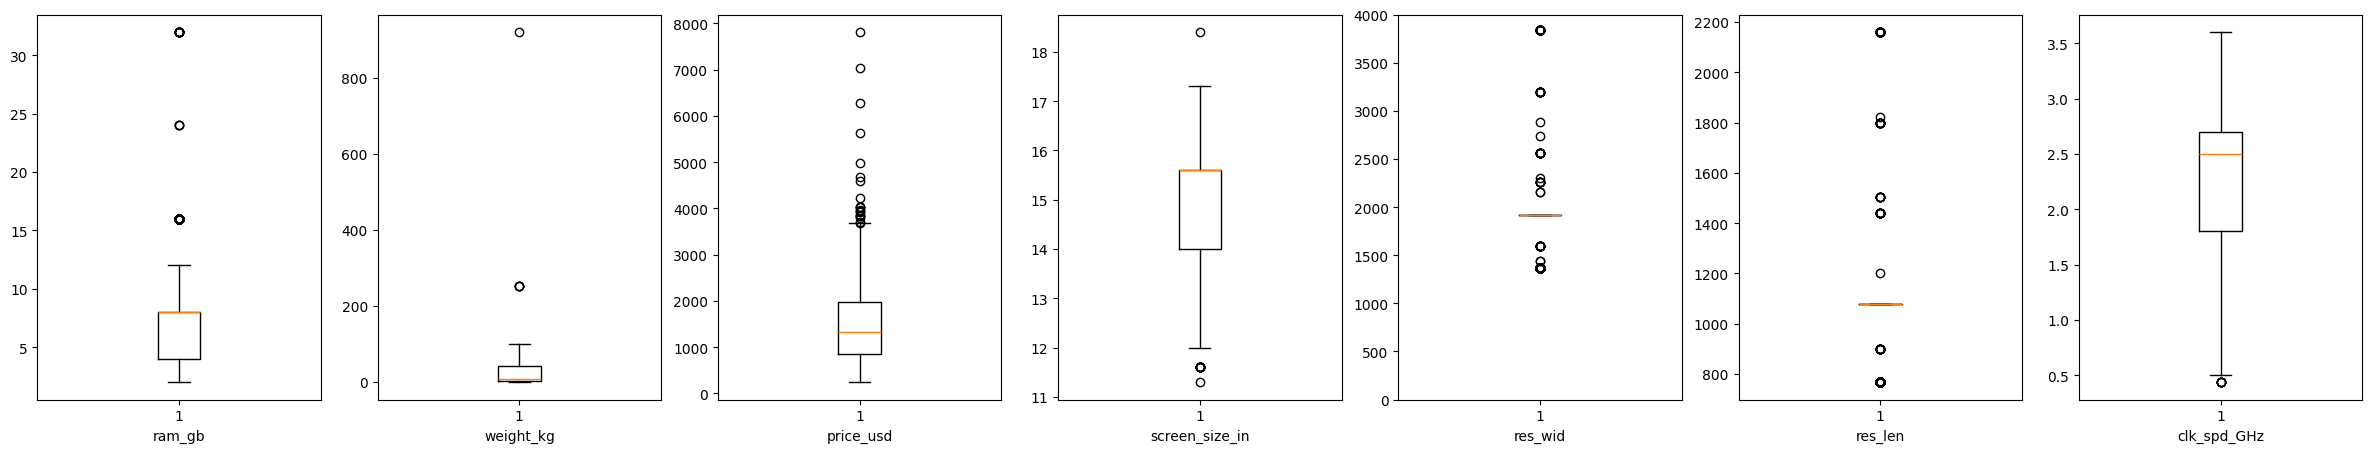

In [23]:
# create boxplots for the numerical variables which will be used in training to detect outliers
numerical_cols = ["ram_gb", "weight_kg", "price_usd", "screen_size_in", "res_wid", "res_len", "clk_spd_GHz"]

plt.figure(figsize=(30,5))
for count, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), count+1)   # adds a subplot to the figure
    plt.boxplot(pc_df[col])
    plt.xlabel(col)

    # resolving display issue with res_wid plot
    if col == "res_wid":
        plt.ylim(0, 4000)

plt.show()

In [24]:
# remove outliers in weight_kg column for pc_df and pc_info_df
BM = pc_df.weight_kg < 200
pc_df = pc_df[BM]
pc_info_df = pc_info_df[BM]

<Axes: >

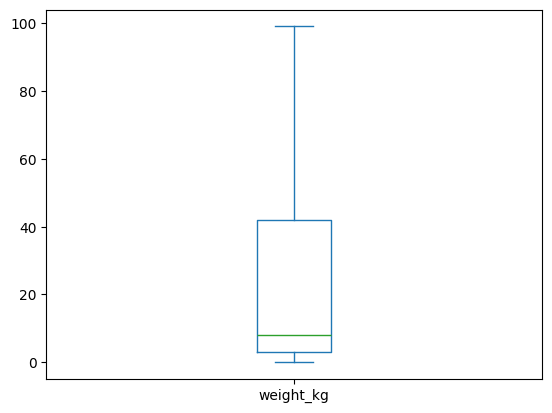

In [25]:
# check weight_kg distribution after removing outliers
pc_df.weight_kg.plot.box()

## Data Cleaning Part III: L2 Normalization

In [26]:
# columns to be normalized: ram_gb, weight_kg, res_wid, res_len
norm_cols = ["ram_gb", "weight_kg", "price_usd", "screen_size_in", "res_wid", "res_len", "clk_spd_GHz"]

In [27]:
# normalize columns
for col in norm_cols:
    pc_df[col] = (
        (pc_df[col] - pc_df[col].min()) / (pc_df[col].max() - pc_df[col].min())
    )

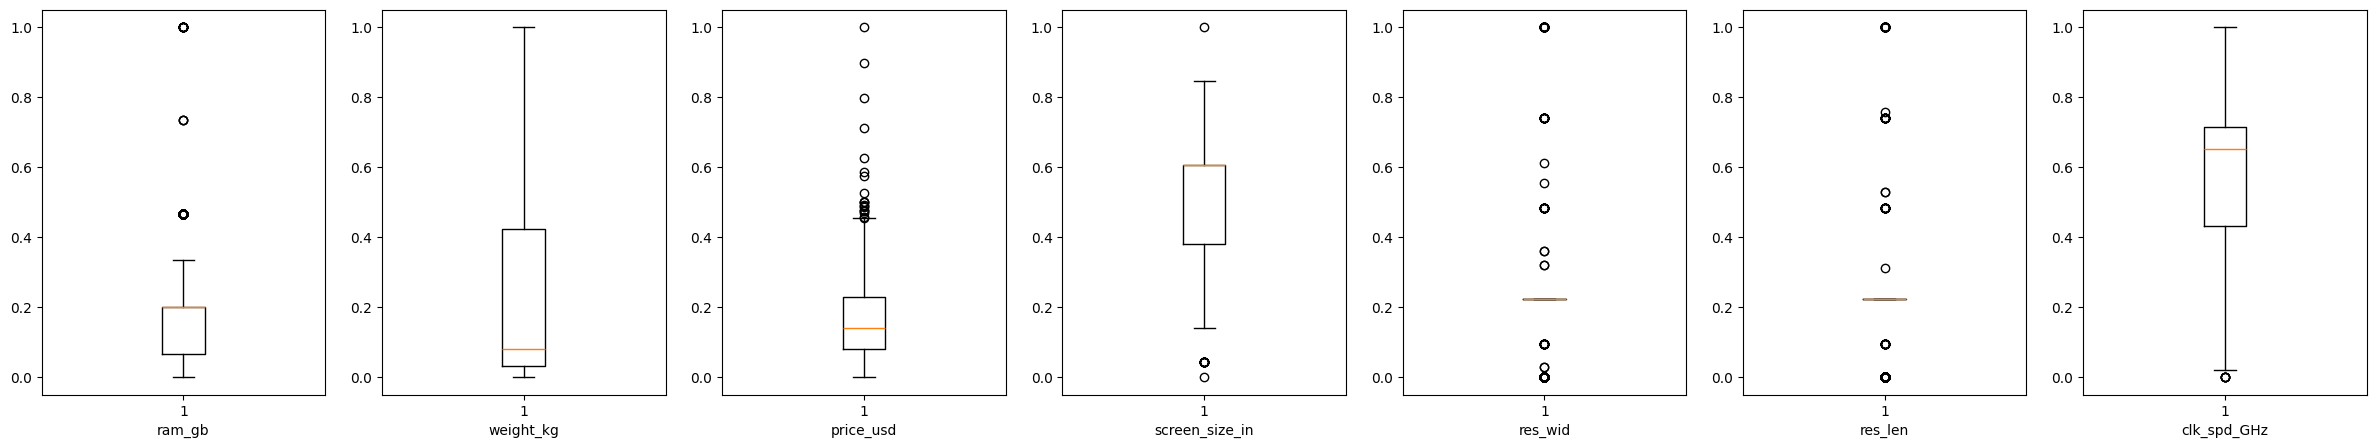

In [28]:
# check distributions after L2 normalization
plt.figure(figsize=(30,5))
for count, col in enumerate(norm_cols):
    plt.subplot(1, len(norm_cols), count+1)   # adds a subplot to the figure
    plt.boxplot(pc_df[col])
    plt.xlabel(col)

plt.show()

In [29]:
pc_df.head()

,ram_gb,weight_kg,price_usd,acer_manufac,apple_manufac,asus_manufac,chuwi_manufac,dell_manufac,fujitsu_manufac,hp_manufac,...,res_wid,res_len,amd_cpu,intel_cpu,clk_spd_GHz,amd_gpu,intel_gpu,nvidia_gpu,mac_os,windows_os
5,0.066667,0.010101,0.035229,True,False,False,False,False,False,False,...,0.000000,0.000000,True,False,0.810127,True,False,False,False,True
6,0.466667,0.040404,0.329784,False,True,False,False,False,False,False,...,0.611964,0.741379,False,True,0.556962,False,True,False,True,False
8,0.466667,0.030303,0.220599,False,False,True,False,False,False,False,...,0.223929,0.224138,False,True,0.430380,False,False,True,False,True
9,0.200000,0.060606,0.097865,True,False,False,False,False,False,False,...,0.223929,0.224138,False,True,0.367089,False,True,False,False,True
13,0.066667,0.020202,0.051971,False,False,False,False,True,False,False,...,0.223929,0.224138,False,True,0.493671,True,False,False,False,True


In [30]:
pc_info_df.head()

,manufacturer,model_name,category,screen_size,screen,cpu,ram,storage,gpu,os,os_version,weight,price_usd
5,Acer,Aspire 3,Notebook,"15.6""",1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows,10,2.1kg,512.179200
6,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS,X,2.04kg,2740.120307
8,Asus,ZenBook UX430UN,Ultrabook,"14.0""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows,10,1.3kg,1914.269760
9,Acer,Swift 3,Ultrabook,"14.0""",IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows,10,1.6kg,985.944960
13,Dell,Inspiron 3567,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows,10,2.2kg,638.815507


In [31]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 5 to 976
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ram_gb                  836 non-null    float64
 1   weight_kg               836 non-null    float64
 2   price_usd               836 non-null    float64
 3   acer_manufac            836 non-null    bool   
 4   apple_manufac           836 non-null    bool   
 5   asus_manufac            836 non-null    bool   
 6   chuwi_manufac           836 non-null    bool   
 7   dell_manufac            836 non-null    bool   
 8   fujitsu_manufac         836 non-null    bool   
 9   hp_manufac              836 non-null    bool   
 10  huawei_manufac          836 non-null    bool   
 11  lg_manufac              836 non-null    bool   
 12  lenovo_manufac          836 non-null    bool   
 13  msi_manufac             836 non-null    bool   
 14  mediacom_manufac        836 non-null    bool   

## Dimensionality Reduction

In [32]:
dr_model = TruncatedSVD(n_components=2, random_state=31337)

In [33]:
pc_dr_data = dr_model.fit_transform(pc_df)

In [34]:
pc_dr_data_df = pd.DataFrame(pc_dr_data)
pc_dr_data_df = pc_dr_data_df.set_index(pc_df.index)
pc_dr_data_df.columns = ["C1", "C2"]
pc_dr_data_df

,C1,C2
5,1.345614,-0.118788
6,1.431395,-0.295120
8,1.684724,0.831606
9,1.707316,-0.463559
13,1.870898,-0.023204
...,...,...
972,2.102228,1.435291
973,2.102782,-0.704267
974,2.022806,1.384925
975,1.855479,0.393684


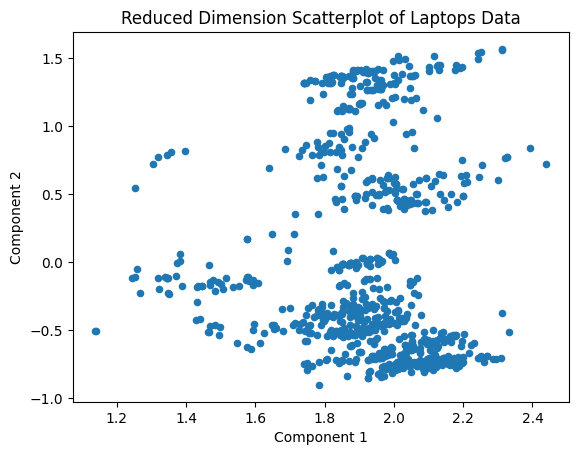

In [35]:
# scatter plot
pc_dr_data_df.plot.scatter(x="C1", y="C2")
plt.title("Reduced Dimension Scatterplot of Laptops Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## Selecting Number of Clusters

In [36]:
rows = []
for k in range(2,21):
    model = KMeans(n_clusters=k, random_state=31337)
    model.fit(pc_dr_data_df)
    rows.append({
        "k": k, 
        "Inertia": model.inertia_
    })

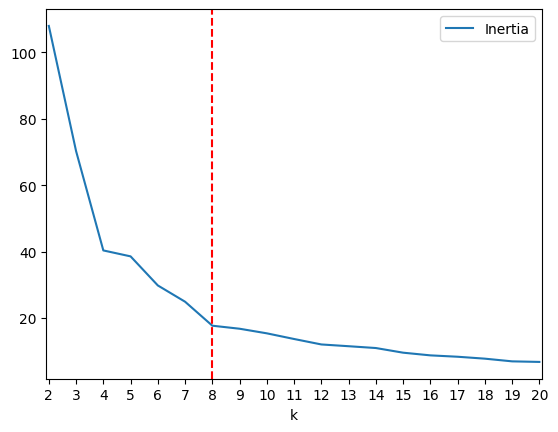

In [37]:
pd.DataFrame(rows).set_index("k").plot(xlim=[1.9,20.1], xticks=list(range(2, 21, 1)))


plt.axvline(x=8, color="red", linestyle="dashed")
plt.show()

## Model Training and Results

In [41]:
model = KMeans(n_clusters=8, random_state=31337)

In [42]:
model.fit(pc_dr_data_df)

KMeans(random_state=31337)

In [43]:
clusters_df = pd.DataFrame(model.predict(pc_dr_data_df), columns=["cluster"])
clusters_df.index = pc_df.index
clusters_df.head()

,cluster
5,3
6,3
8,5
9,7
13,6


In [44]:
clusters_df["cluster"].value_counts()

cluster
7    177
1    153
2    134
0    102
4    102
6     68
3     53
5     47
Name: count, dtype: int64

In [45]:
for i in range(0,8):
    this_cluster = clusters_df[clusters_df["cluster"] == i]
    print("CLUSTER #", i)
    
    this_cluster_feats = pd.DataFrame(pc_df.loc[this_cluster.index].mean(axis=0), columns=["mean"])
    display(this_cluster_feats.sort_values(by="mean", ascending=False).head(5))

    # print info about 2 laptops from each cluster
    for pc in list(this_cluster.index)[0:2]:
        print(pc_info_df.loc[pc])
        print("----"*10)

CLUSTER # 0


,mean
windows_os,1.000000
intel_cpu,1.000000
nvidia_gpu,0.980392
notebook_cat,0.970588
screen_size_in,0.660591


manufacturer                            HP
model_name                     ProBook 470
category                          Notebook
screen_size                          17.3"
screen                   Full HD 1920x1080
cpu             Intel Core i5 8250U 1.6GHz
ram                                    8GB
storage                            1TB HDD
gpu                   Nvidia GeForce 930MX
os                                 Windows
os_version                              10
weight                               2.5kg
price_usd                      1147.281408
Name: 29, dtype: object
----------------------------------------
manufacturer                            HP
model_name                     ProBook 450
category                          Notebook
screen_size                          15.6"
screen                   Full HD 1920x1080
cpu             Intel Core i5 8250U 1.6GHz
ram                                    8GB
storage                          256GB SSD
gpu                  Nvidia GeFo

,mean
windows_os,1.000000
intel_gpu,1.000000
intel_cpu,1.000000
notebook_cat,1.000000
clk_spd_GHz,0.613634


manufacturer                        Dell
model_name                 Inspiron 3567
category                        Notebook
screen_size                        15.6"
screen                          1366x768
cpu             Intel Core i3 6006U 2GHz
ram                                  4GB
storage                          1TB HDD
gpu                Intel HD Graphics 520
os                               Windows
os_version                            10
weight                             2.3kg
price_usd                     536.046751
Name: 25, dtype: object
----------------------------------------
manufacturer                            HP
model_name                          250 G6
category                          Notebook
screen_size                          15.6"
screen                            1366x768
cpu             Intel Core i5 7200U 2.5GHz
ram                                    4GB
storage                            1TB HDD
gpu                  Intel HD Graphics 620
os             

,mean
windows_os,1.000000
nvidia_gpu,1.000000
intel_cpu,1.000000
gaming_cat,0.985075
clk_spd_GHz,0.728179


manufacturer                         Lenovo
model_name               Legion Y520-15IKBN
category                             Gaming
screen_size                           15.6"
screen          IPS Panel Full HD 1920x1080
cpu             Intel Core i5 7300HQ 2.5GHz
ram                                     8GB
storage                128GB SSD +  1TB HDD
gpu                 Nvidia GeForce GTX 1050
os                                  Windows
os_version                               10
weight                                2.5kg
price_usd                       1279.167552
Name: 21, dtype: object
----------------------------------------
manufacturer                           Dell
model_name                    Inspiron 7577
category                             Gaming
screen_size                           15.6"
screen          IPS Panel Full HD 1920x1080
cpu             Intel Core i7 7700HQ 2.8GHz
ram                                    16GB
storage                256GB SSD +  1TB HDD
gpu        

,mean
windows_os,0.943396
amd_gpu,0.792453
amd_cpu,0.754717
notebook_cat,0.735849
clk_spd_GHz,0.585861


manufacturer                       Acer
model_name                     Aspire 3
category                       Notebook
screen_size                       15.6"
screen                         1366x768
cpu             AMD A9-Series 9420 3GHz
ram                                 4GB
storage                       500GB HDD
gpu                       AMD Radeon R5
os                              Windows
os_version                           10
weight                            2.1kg
price_usd                      512.1792
Name: 5, dtype: object
----------------------------------------
manufacturer                                 Apple
model_name                             MacBook Pro
category                                 Ultrabook
screen_size                                  15.4"
screen          IPS Panel Retina Display 2880x1800
cpu                           Intel Core i7 2.2GHz
ram                                           16GB
storage                        256GB Flash Storage
gpu     

,mean
windows_os,1.000000
intel_gpu,1.000000
intel_cpu,1.000000
notebook_cat,1.000000
screen_size_in,0.467688


manufacturer                          Chuwi
model_name                    LapBook 15.6"
category                           Notebook
screen_size                           15.6"
screen                    Full HD 1920x1080
cpu             Intel Atom x5-Z8300 1.44GHz
ram                                     4GB
storage                  64GB Flash Storage
gpu                       Intel HD Graphics
os                                  Windows
os_version                               10
weight                               1.89kg
price_usd                        313.696956
Name: 30, dtype: object
----------------------------------------
manufacturer                                  Lenovo
model_name                        IdeaPad 120S-14IAP
category                                    Notebook
screen_size                                    14.0"
screen                                      1366x768
cpu             Intel Celeron Dual Core N3350 1.1GHz
ram                                          

,mean
windows_os,1.000000
nvidia_gpu,0.872340
intel_cpu,0.872340
clk_spd_GHz,0.692971
screen_size_in,0.605034


manufacturer                          Asus
model_name                 ZenBook UX430UN
category                         Ultrabook
screen_size                          14.0"
screen                   Full HD 1920x1080
cpu             Intel Core i7 8550U 1.8GHz
ram                                   16GB
storage                          512GB SSD
gpu                   Nvidia GeForce MX150
os                                 Windows
os_version                              10
weight                               1.3kg
price_usd                       1914.26976
Name: 8, dtype: object
----------------------------------------
manufacturer                               Dell
model_name                        Inspiron 7773
category                     2 in 1 Convertible
screen_size                               17.3"
screen          Full HD / Touchscreen 1920x1080
cpu                  Intel Core i5 8250U 1.6GHz
ram                                        12GB
storage                                 1

,mean
windows_os,1.000000
intel_cpu,1.000000
amd_gpu,0.970588
notebook_cat,0.897059
dell_manufac,0.661765


manufacturer                        Dell
model_name                 Inspiron 3567
category                        Notebook
screen_size                        15.6"
screen                 Full HD 1920x1080
cpu             Intel Core i3 6006U 2GHz
ram                                  4GB
storage                        256GB SSD
gpu                   AMD Radeon R5 M430
os                               Windows
os_version                            10
weight                             2.2kg
price_usd                     638.815507
Name: 13, dtype: object
----------------------------------------
manufacturer                          Dell
model_name                   Inspiron 3567
category                          Notebook
screen_size                          15.6"
screen                   Full HD 1920x1080
cpu             Intel Core i7 7500U 2.7GHz
ram                                    8GB
storage                          256GB SSD
gpu                     AMD Radeon R5 M430
os             

,mean
windows_os,1.000000
intel_gpu,1.000000
intel_cpu,1.000000
ultrabook_cat,0.576271
clk_spd_GHz,0.566795


manufacturer                           Acer
model_name                          Swift 3
category                          Ultrabook
screen_size                           14.0"
screen          IPS Panel Full HD 1920x1080
cpu              Intel Core i5 8250U 1.6GHz
ram                                     8GB
storage                           256GB SSD
gpu                  Intel UHD Graphics 620
os                                  Windows
os_version                               10
weight                                1.6kg
price_usd                         985.94496
Name: 9, dtype: object
----------------------------------------
manufacturer                                         Dell
model_name                                         XPS 13
category                                        Ultrabook
screen_size                                         13.3"
screen          IPS Panel Full HD / Touchscreen 1920x1080
cpu                            Intel Core i5 8250U 1.6GHz
ram             

## Clusters Visualization

In [46]:
# merge cluster and reduced data
merge_pc_dr_cluster_df = pc_dr_data_df.merge(clusters_df, left_index=True, right_index=True)
merge_pc_dr_cluster_df

,C1,C2,cluster
5,1.345614,-0.118788,3
6,1.431395,-0.295120,3
8,1.684724,0.831606,5
9,1.707316,-0.463559,7
13,1.870898,-0.023204,6
...,...,...,...
972,2.102228,1.435291,2
973,2.102782,-0.704267,1
974,2.022806,1.384925,2
975,1.855479,0.393684,0


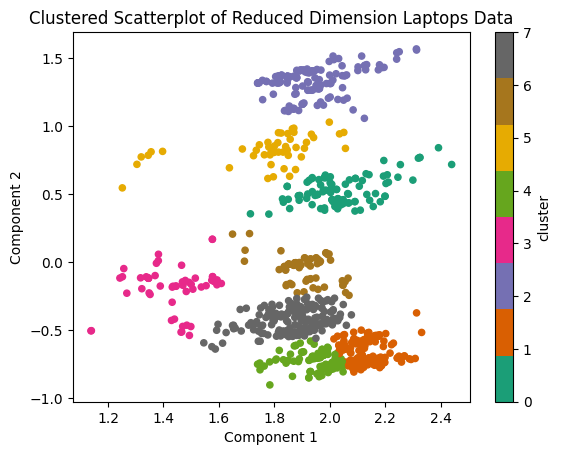

In [47]:
# scatter plot
merge_pc_dr_cluster_df.plot.scatter(x="C1", y="C2", c="cluster", cmap="Dark2")
plt.title("Clustered Scatterplot of Reduced Dimension Laptops Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()